# Анализ поведения клиентов для сети фитнес-центров "Культурист-датасаентист"

## Описание проекта

### Цель анализа

Снизить отток клиентов

### Задачи анализа

Для того, чтобы снизить отток клиентов, необходимо:

- Научиться прогнозировать вероятность оттока (на периоде в месяц)
- сформировать типичные портреты клиентов
- проанализировать основные признаки, влияющие на отток

### Структура проекта

- **Описание проекта** - кратко описываются цели, задачи и структура проекта.
- **Подготовка данных** - выполняется очистка данных, проводится исследовательский анализ данных.
- **Прогнозирование** - строятся модели, выполняется анализ и прогнозирование на основе обученных моделей.
- **Кластеризация** - формируются группы клиентов.
- **Выводы и рекомендации** - на основании проделанной работы формулируются выводы и рекомендации.

## Подготовка данных

### Подготовка

In [1]:
pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score,recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats as st
from matplotlib import colors
from phik import resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from matplotlib.ticker import AutoLocator

import phik

In [3]:
raw_data = pd.read_csv(r'/datasets/gym_churn.csv')
raw_data.columns=raw_data.columns.map(lambda x: x.lower())
display(raw_data.info())
display(raw_data.head())
display(raw_data.dropna().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

None

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

None

Пропуски в данных отсутствуют. Текстовые данные отсутствуют. Данные готовы к дальнейшей обработке и анализу.

Для удобства восприятия далее составим словарь названий столбцов на русском языке.

In [4]:
raw_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
col_names={'gender':'пол', 'near_location':'рядом', 'partner':'партнер', 'promo_friends':'приведи_друга', 'phone':'телефон',
       'contract_period':'длит_абонемента', 'group_visits':'групповые_занятия', 'age':'возраст',
       'avg_additional_charges_total':'средн_плата_доп', 'month_to_end_contract':'месяцев_до_окончания_абонемента',
           'lifetime':'срок_жизни', 'avg_class_frequency_total':'частота_посещений_общ',
           'avg_class_frequency_current_month':'частота_посещений_прош_месяц','churn':'ушел', 'cluster_id':'кластер'}

In [6]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [7]:
plt.rcParams['axes.grid'] = False

In [8]:
def classify_data(df,excl_cat=''):
    cat_dict ={}
    for col in df.columns:
        if col!=excl_cat:
            if df[col].isin([0,1]).all():
                cat_dict[col]='cat'
            else:
                cat_dict[col]='num'
    return cat_dict

In [9]:
def plot_df(df,n_cols,w,h,by_cat):
    col_cat=classify_data(df,by_cat)
    #отбираем отдельно категориальные и отдельно количественные признаки
    cat_att=[]
    num_att=[]
    
    for i in col_cat:
        if (col_cat[i] == 'cat') & (col_cat[i] != by_cat):
            cat_att.append(i)
        else:
            num_att.append(i)
    cat_no = len(cat_att)*2
    num_no=len(num_att)*2
    tot_no = cat_no+num_no
    rows_cat = cat_no//n_cols
    if cat_no % n_cols !=0:
        rows_cat += 1
    tot_no+=cat_no % n_cols
    rows_num = num_no//n_cols
    if num_no % n_cols !=0:
        rows_num += 1
    rows_tot = rows_cat + rows_num
    #print(cat_no)
    #print(rows_tot)
    if cat_no % 2 !=0:
        num_st_pos = cat_no + 1
    else:
        num_st_pos = cat_no
    #print(cat_no)
    #print(num_st_pos)
    
    #print(rows_cat)
    #print(tot_no)
    position = range(1,tot_no+1)
    #print(tot_no)
    
    fig = plt.figure(figsize=(w,h*rows_tot))
    fig.tight_layout()
    f = 0
    a = 0
    for i in range(len(cat_att)+len(num_att)):
        if i - len(cat_att) < 0:
            #print(i)
            #print(cat_att[i])
            #display(render_df)
            for d in (0,1):
                a += d
                #print(a)
                ax = fig.add_subplot(rows_tot,n_cols,position[i+a])
                #sns.barplot(df.groupby(by_cat)[cat_att[i]].sum())
                sns.barplot(y=cat_att[i],x=cat_att[i], data=pd.DataFrame(df.loc[df[by_cat]==d,
                                                                                           cat_att[i]].value_counts()))
                ax.set_title(col_names[cat_att[i]] + ', ' + col_names[by_cat] + '='+str(d))
                ax.set_ylabel(col_names[cat_att[i]])
                ax.set_xticks(df[cat_att[i]].unique())
                ax.set_xticklabels(df[cat_att[i]].unique())
                #ax.legend(df[cat_att[i]].unique())
                ax.set_xlabel('')
            #ax.set_xticks([0,1])
            #xt=ax.get_xticks()
            #print(xt)
            #yt=ax.get_yticks()
            #print(yt[0])
            #ax.yaxis.set_major_locator(AutoLocator())
            #ax.xaxis.set_major_locator(AutoLocator())
            #print()
            #ax.set_yticks(df[cat_att[i]])
        else:
            #print('i', i-cat_no)
            z = num_st_pos + i-len(cat_att) + f
            #print('z', z)
            ax = fig.add_subplot(rows_tot,n_cols,position[z])
            sns.histplot(x=df[num_att[i-cat_no]],hue = df[by_cat])
            ax.set_title(col_names[num_att[i-cat_no]])
            ax.set_xlabel('')
            ax.set_ylabel('Кол-во')
            plt.xticks(rotation=70)
            f +=1
            z = num_st_pos + i-len(cat_att) + f
            ax = fig.add_subplot(rows_tot,n_cols,position[z])
            sns.boxplot(x=df[num_att[i-cat_no]],hue=df[by_cat])
            ax.set_title(col_names[num_att[i-cat_no]])
            ax.set_xlabel('')
            plt.xticks(rotation=70)
    plt.show()

In [10]:
def b_g_r(s):
    cm=sns.color_palette("RdYlGn_r", as_cmap=True)
    max_val = max(s.max(), abs(s.min()))
    norm = colors.Normalize(0,max_val)
    normed = norm(abs(s.values))
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [11]:
def b_g(s):
    cm=sns.color_palette("RdYlGn", as_cmap=True)
    max_val = max(s.max(), abs(s.min()))
    norm = colors.Normalize(0,max_val)
    normed = norm(abs(s.values))
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

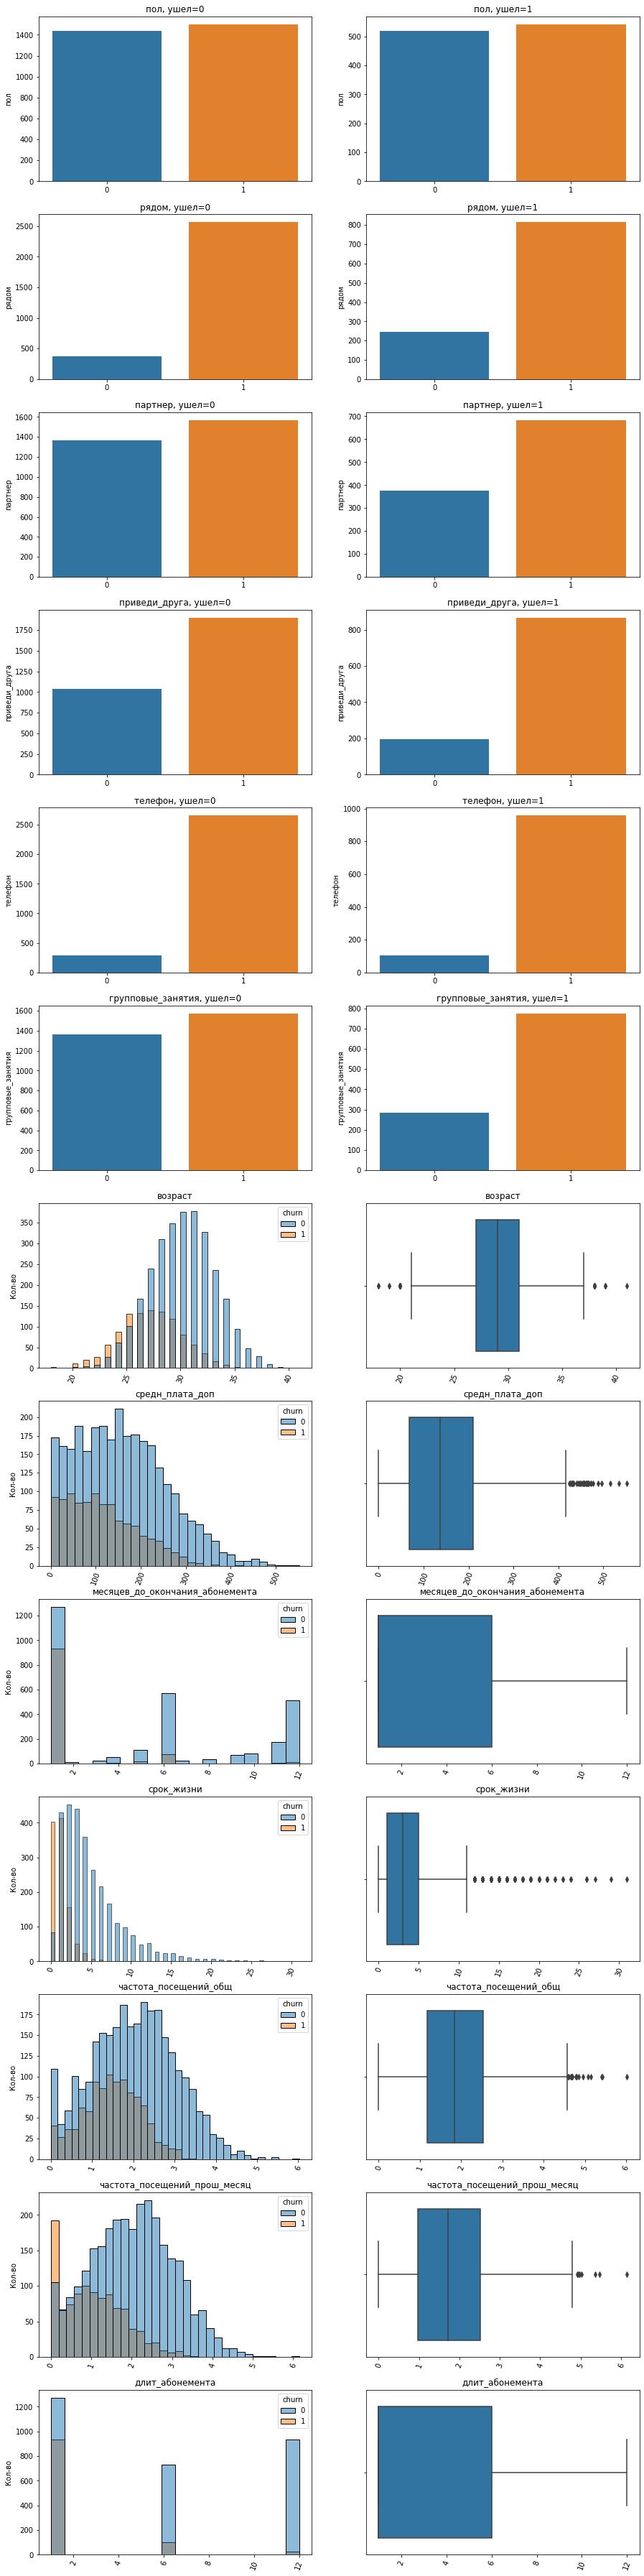

In [12]:
plot_df(raw_data,2,15,5,'churn')

In [13]:
data_grouped = raw_data.groupby('churn').agg('mean')
display(data_grouped.T)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Анализ средних показателей для действующих клиентов и ушедших клиентов показывает, что:
1) Мужчин и женщин среди клиентов приблизительно поровну

2) Среди действующих клиентов больше тех, кто живет или работает неподалеку от фитнес-центра

3) Среди действующих клиентов больше сотрудников компании-партнера клуба

4) Среди действующих клиентов больше тех, кто первоначально записался в рамках акции "приведи друга"

5) Длительность текущего действующего абонемента у дейтсвующих клиентов в среднем намного выше, чем у ушедших

6) В среднем действующие клиенты чаще посещают групповые занятия

7) Действующие клиенты в среднем старше, чем уходящие

8) Выручка от других услуг фитнес-центра больше в группе действующих клиентов

9) Уходящие клиенты чаще всего уходят в последний месяц действия абонемента

10) Действующие клиенты в среднем чаще посещают зал (2 раза в неделю против 1,5 раз в неделю у уходящих)

11) Действующие клиенты за последний месяц в среднем посещают зал 2 раза в неделю, уходящие - 1 раз в неделю

12) Уходящие клиенты в среднем ходят в зал всего 1 месяц, в отличие от действующих

Сравнительные графы выше подтверждают наблюдения, сделанные при сравнении средних величин. Отдельно стоит отметить некоторые выбросы для уходящих клиентов по признаку "срок до окончания абонемента" и "срок действия абонемента" - есть некоторое количество уходящих клиентов, для которых оба показателя находятся в районе 6 и 12 месяцев; однако, срок "жизни" клиента в группе уходящих все равно не превышает 8 месяцев, поэтому, скорее всего, это нетипичные клиенты. Выясним в ходе дальнейшего анализа.

### Смотрим корреляции

Проверяем корреляцию между признаком "ухода клиента" и другими признаками.

In [14]:
alpha = 0.05
categories=classify_data(raw_data)
for col in raw_data.columns:
    if categories[col]!='cat':
        statistic, p_value = st.normaltest(raw_data[col])
        if p_value > alpha:
            result = 'Normal'
        else:
            result = 'NOT Normal'
        display(f"{col} - D'Agostino & Pearson: {result:>11s}")
        display(statistic)

"contract_period - D'Agostino & Pearson:  NOT Normal"

2603.2416270092476

"age - D'Agostino & Pearson:      Normal"

5.546273089729783

"avg_additional_charges_total - D'Agostino & Pearson:  NOT Normal"

217.10335948103574

"month_to_end_contract - D'Agostino & Pearson:  NOT Normal"

900.5806686338035

"lifetime - D'Agostino & Pearson:  NOT Normal"

1599.2193314774104

"avg_class_frequency_total - D'Agostino & Pearson:  NOT Normal"

51.36068347250644

"avg_class_frequency_current_month - D'Agostino & Pearson:  NOT Normal"

107.85173559546348

In [15]:
phik_overview=raw_data.phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011302,0.000000,0.000000,0.000000,0.006725,0.000000,0.000000,0.000000
near_location,0.000000,1.000000,0.000000,0.323394,0.000000,0.089690,0.238378,0.074166,0.116087,0.187983,0.057505,0.056060,0.074947,0.197164
partner,0.000000,0.000000,1.000000,0.650879,0.000000,0.187941,0.024482,0.055666,0.029261,0.394947,0.102712,0.000000,0.023412,0.243579
promo_friends,0.000000,0.323394,0.650879,1.000000,0.000000,0.149387,0.185199,0.055876,0.068440,0.331498,0.104268,0.036573,0.062685,0.250009
phone,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035631,0.000000,0.000000,0.000000
contract_period,0.000000,0.089690,0.187941,0.149387,0.000000,1.000000,0.101860,0.160177,0.135359,0.970609,0.197495,0.145679,0.183997,0.247718
group_visits,0.011302,0.238378,0.024482,0.185199,0.000000,0.101860,1.000000,0.094863,0.050954,0.217600,0.101198,0.072465,0.090611,0.270011
age,0.000000,0.074166,0.055666,0.055876,0.000000,0.160177,0.094863,1.000000,0.081849,0.131217,0.163072,0.149835,0.213962,0.524050
avg_additional_charges_total,0.000000,0.116087,0.029261,0.068440,0.000000,0.135359,0.050954,0.081849,1.000000,0.127984,0.014526,0.091503,0.060987,0.257619
month_to_end_contract,0.000000,0.187983,0.394947,0.331498,0.000000,0.970609,0.217600,0.131217,0.127984,1.000000,0.228635,0.175876,0.193270,0.519155


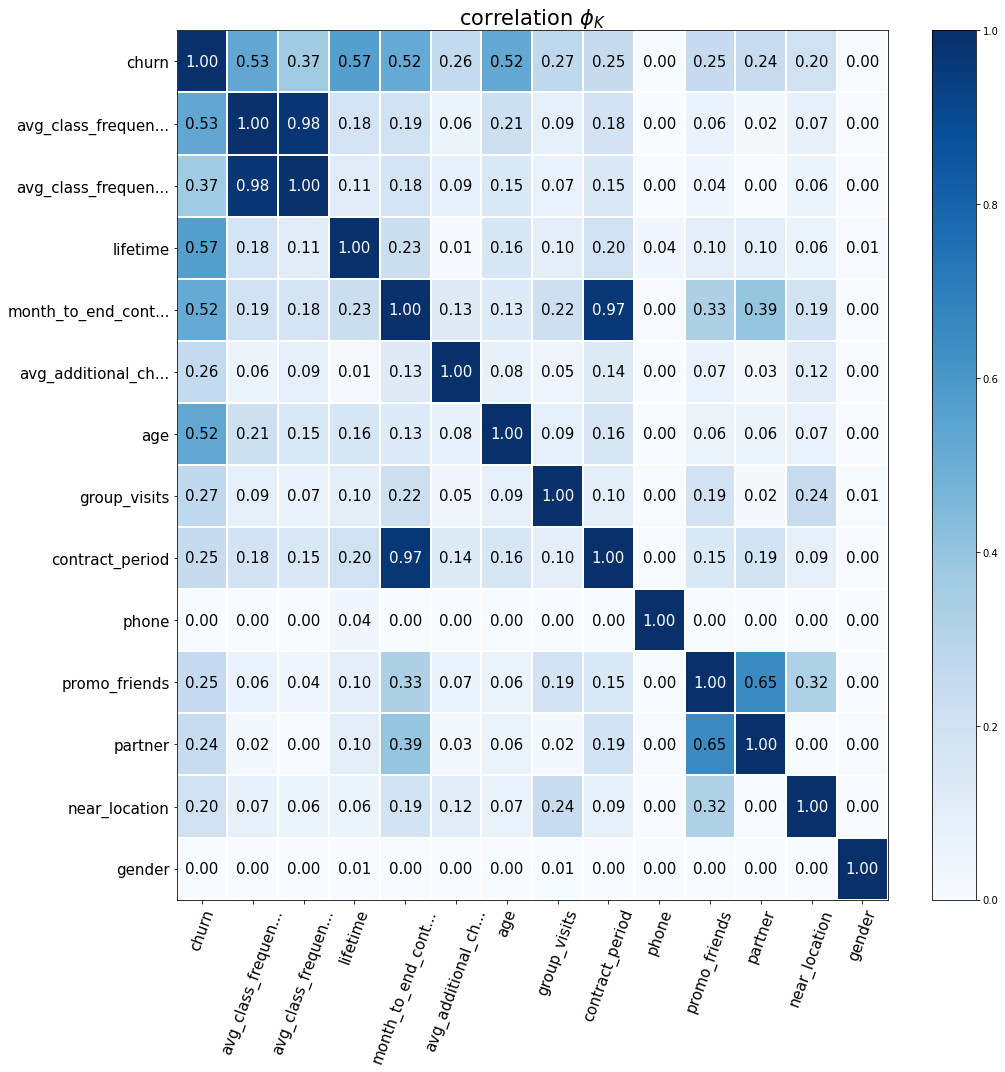

In [16]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))

plt.xticks(rotation=70)
plt.tight_layout()

Выводы:

Сначала - признаки, по которым имеется наиболее сильная зависимость:
- чем дольше клиент ходит в фитнес-центр, тем меньше вероятность того, что этот клиент будет в группе уходящих
- чем чаще клиент ходил на занятия в последний месяц, тем меньше вероятность того, что этот клиент будет в группе уходящих
- чем старше клиент, тем меньше вероятность, что этот клиент будет в группе уходящих
- чем больше срок абонемента и чем больше времени осталось до окончания абонемента, тем меньше вероятность, что этот клиент будет в группе уходящих

Далее - признаки с достаточно низким уровнем зависимости:
- чем чаще ходит клиент на занятия в целом, тем меньше вероятность, что этот клиент будет в группе уходящих
- чем больше клиент тратит на дополнительные услуги, тем меньше вероятность, что этот клиент будет в группе уходящих
- чем больше клиент посещает групповых занятий, тем меньше вероятность, что этот клиент будет в группе уходящих
- если клиент пришел по промокоду от друга, вероятность того, что он будет в группе уходящих, меньше
- если клиент является сотрудником компании-партнера клуба, вероятность того, что он будет в группе уходящих, меньше
- если клиент живет или работает недалеко от фитнес-центра, вероятность того, что он будет в группе уходящих, меньше

Связи между принадлежностью клиента к группе уходящих и полом клиента, а также наличием его номера телефона, нет.

## Прогнозирование

### Построение моделей

Создаем обучающую и валидационную выборки

In [17]:
X=raw_data.drop(columns='churn')
y=raw_data['churn']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Стандартизируем признаки.

In [19]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)

In [20]:
X_test_st = scaler.transform(X_test)

Задаем модели - воспользуемся логистической регрессией и моделью случайного леса.

In [21]:
lr_model=LogisticRegression(random_state=0, max_iter=2000)
rf_model=RandomForestClassifier(random_state=0,n_estimators=200)

In [22]:
models = [
    lr_model,
    rf_model,
]

In [23]:
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape

In [24]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(
            accuracy_score(y_test,y_pred),
            precision_score(y_test,y_pred),
            recall_score(y_test,y_pred),
        )
    )

In [25]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(max_iter=2000, random_state=0)
Accuracy:0.92 Precision:0.85 Recall:0.83 
RandomForestClassifier(n_estimators=200, random_state=0)
Accuracy:0.92 Precision:0.85 Recall:0.83 


Для решения нашей задачи можно использовать любую из двух выбранных моделей, так как параметры доли правильных ответов, точности прогноза, полноты с заданными параметрами одинаковы.

## Кластеризация клиентов

Для кластеризации необходимо стандартизировать наши данные.

Затем построим дендрограмму.

In [26]:
X_sc = scaler.fit_transform(raw_data.drop(columns='churn'))

linked=linkage(X_sc, method = 'ward')

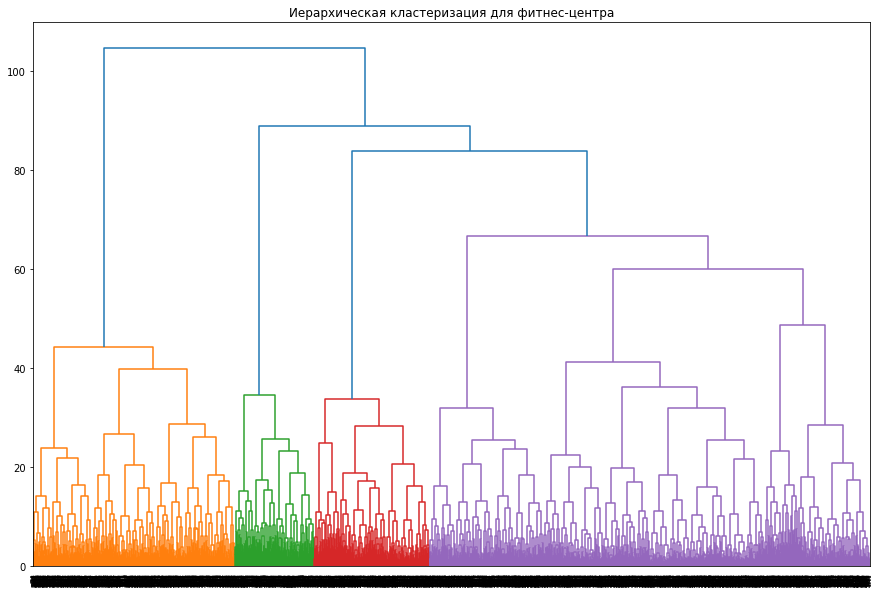

In [27]:
plt.figure(figsize=(15,10))
dendrogram(linked,orientation='top')
plt.title('Иерархическая кластеризация для фитнес-центра')
plt.show()

На основании дендрограммы предполагаем, что оптимальное число кластеров составляет 4-6, выбираем 5.

In [28]:
km = KMeans(n_clusters=5,random_state=0)
labels = km.fit_predict(X_sc)
raw_data['cluster_id']=labels
display(labels)

array([1, 0, 3, ..., 0, 0, 1], dtype=int32)

In [29]:
raw_data['cluster_id']=raw_data['cluster_id'].map(lambda x: int(x+1))

In [30]:
compare_data = raw_data.groupby(['cluster_id']).agg('mean')-raw_data.loc[raw_data['churn']==1
                                                                        ].groupby(['cluster_id']).agg('mean')
#for i in compare_data.columns:
#    if abs(compare_data[i].min()) < abs(compare_data[i].max()):
#        compare_data.loc[5,i]=1
#    else:
#        compare_data.loc[5,i]=0
display(compare_data.drop(columns='churn').round(2).transpose().style.apply(b_g, axis=1))

cluster_id,1,2,3,4,5
gender,-0.100000,-0.000000,-0.000000,-0.020000,-0.000000
near_location,-0.000000,0.070000,0.000000,0.000000,-0.020000
partner,-0.040000,0.080000,0.070000,0.030000,0.060000
promo_friends,-0.030000,0.150000,0.040000,0.020000,0.110000
phone,0.000000,0.000000,0.000000,0.000000,-0.000000
contract_period,1.030000,2.990000,0.900000,0.480000,1.060000
group_visits,0.190000,0.100000,0.060000,0.060000,0.070000
age,3.300000,2.160000,1.500000,1.290000,1.970000
avg_additional_charges_total,36.250000,35.040000,17.180000,17.800000,38.310000
month_to_end_contract,0.850000,2.720000,0.800000,0.430000,0.900000


In [31]:
compare_data1 = raw_data.groupby('cluster_id').mean()
compare_data2 = raw_data.groupby('cluster_id').median()
display(raw_data.groupby('cluster_id')['gender'].count().to_frame().T)
display(compare_data1.round(2).transpose().style.apply(b_g, axis=1))
display(compare_data2.round(2).transpose().style.apply(b_g, axis=1))

cluster_id,1,2,3,4,5
gender,1010,385,505,1262,838


cluster_id,1,2,3,4,5
gender,0.500000,0.520000,0.500000,0.490000,0.560000
near_location,0.960000,0.860000,0.000000,1.000000,0.980000
partner,0.780000,0.470000,0.460000,0.350000,0.360000
promo_friends,0.570000,0.310000,0.080000,0.240000,0.230000
phone,1.000000,0.000000,1.000000,1.000000,1.000000
contract_period,10.890000,4.790000,2.350000,1.950000,2.670000
group_visits,0.540000,0.430000,0.220000,0.340000,0.470000
age,29.980000,29.300000,28.480000,28.170000,30.130000
avg_additional_charges_total,160.760000,143.960000,135.460000,131.620000,161.660000
month_to_end_contract,9.950000,4.480000,2.200000,1.860000,2.460000


cluster_id,1,2,3,4,5
gender,1.000000,1.000000,0.000000,0.000000,1.000000
near_location,1.000000,1.000000,0.000000,1.000000,1.000000
partner,1.000000,0.000000,0.000000,0.000000,0.000000
promo_friends,1.000000,0.000000,0.000000,0.000000,0.000000
phone,1.000000,0.000000,1.000000,1.000000,1.000000
contract_period,12.000000,1.000000,1.000000,1.000000,1.000000
group_visits,1.000000,0.000000,0.000000,0.000000,0.000000
age,30.000000,29.000000,29.000000,28.000000,30.000000
avg_additional_charges_total,156.460000,136.920000,125.000000,119.230000,149.620000
month_to_end_contract,11.000000,1.000000,1.000000,1.000000,1.000000


Анализ кластеров по средним и медианным значениям показывает основные различия, на основании которых можем переименовать кластеры:
Кластер 1 - "Долговременные"
Кластер 2 - "Без номера телефона"
Кластер 3 - "Далеко живут"
Кластер 4 - "Молодые"
Кластер 5 - "Активные"

In [32]:
clusters = {1:'долговременные', 2:'без_телефона',3:'далеко',4:'молодые',5:'активные'}

In [33]:
raw_data['cluster_id']=raw_data['cluster_id'].map(lambda x: clusters[x])

In [34]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [35]:
raw_data['cluster_id'].sort_values().unique()

array(['активные', 'без_телефона', 'далеко', 'долговременные', 'молодые'],
      dtype=object)

'Графики для кластера активные'

'Отток для кластера активные составляет 57 чел. из 838 чел.'

'Доля оттока для кластера активные составляет 6.8%'

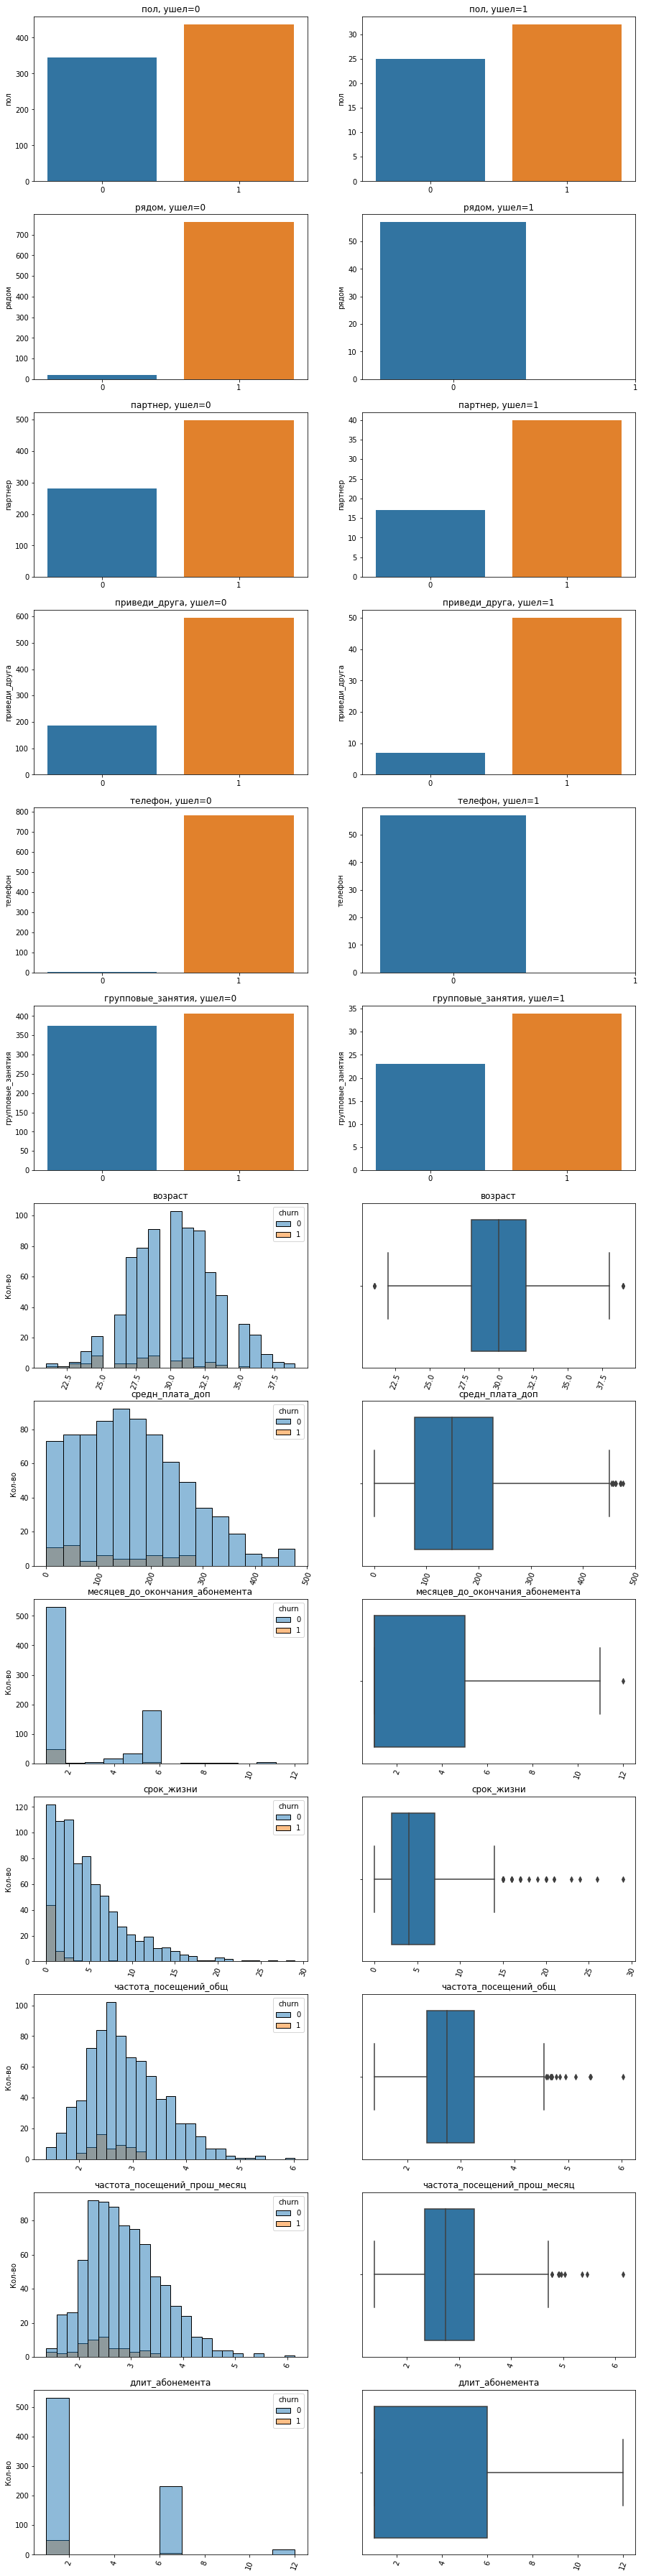

'Графики для кластера без_телефона'

'Отток для кластера без_телефона составляет 103 чел. из 385 чел.'

'Доля оттока для кластера без_телефона составляет 26.75%'

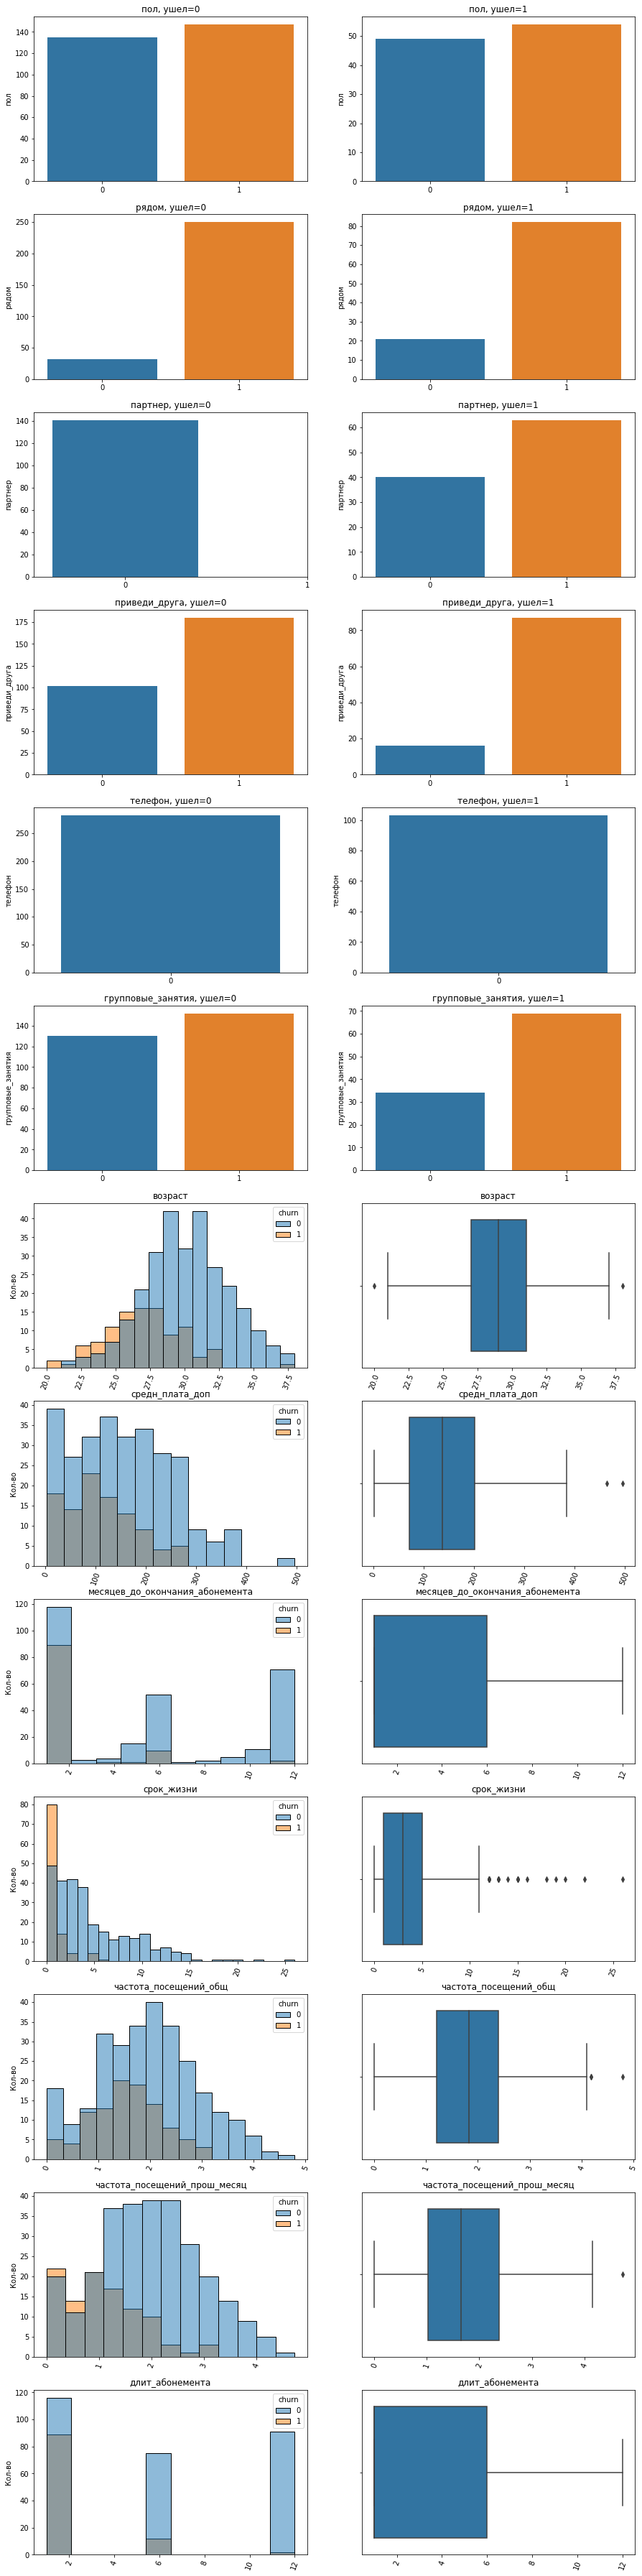

'Графики для кластера далеко'

'Отток для кластера далеко составляет 224 чел. из 505 чел.'

'Доля оттока для кластера далеко составляет 44.36%'

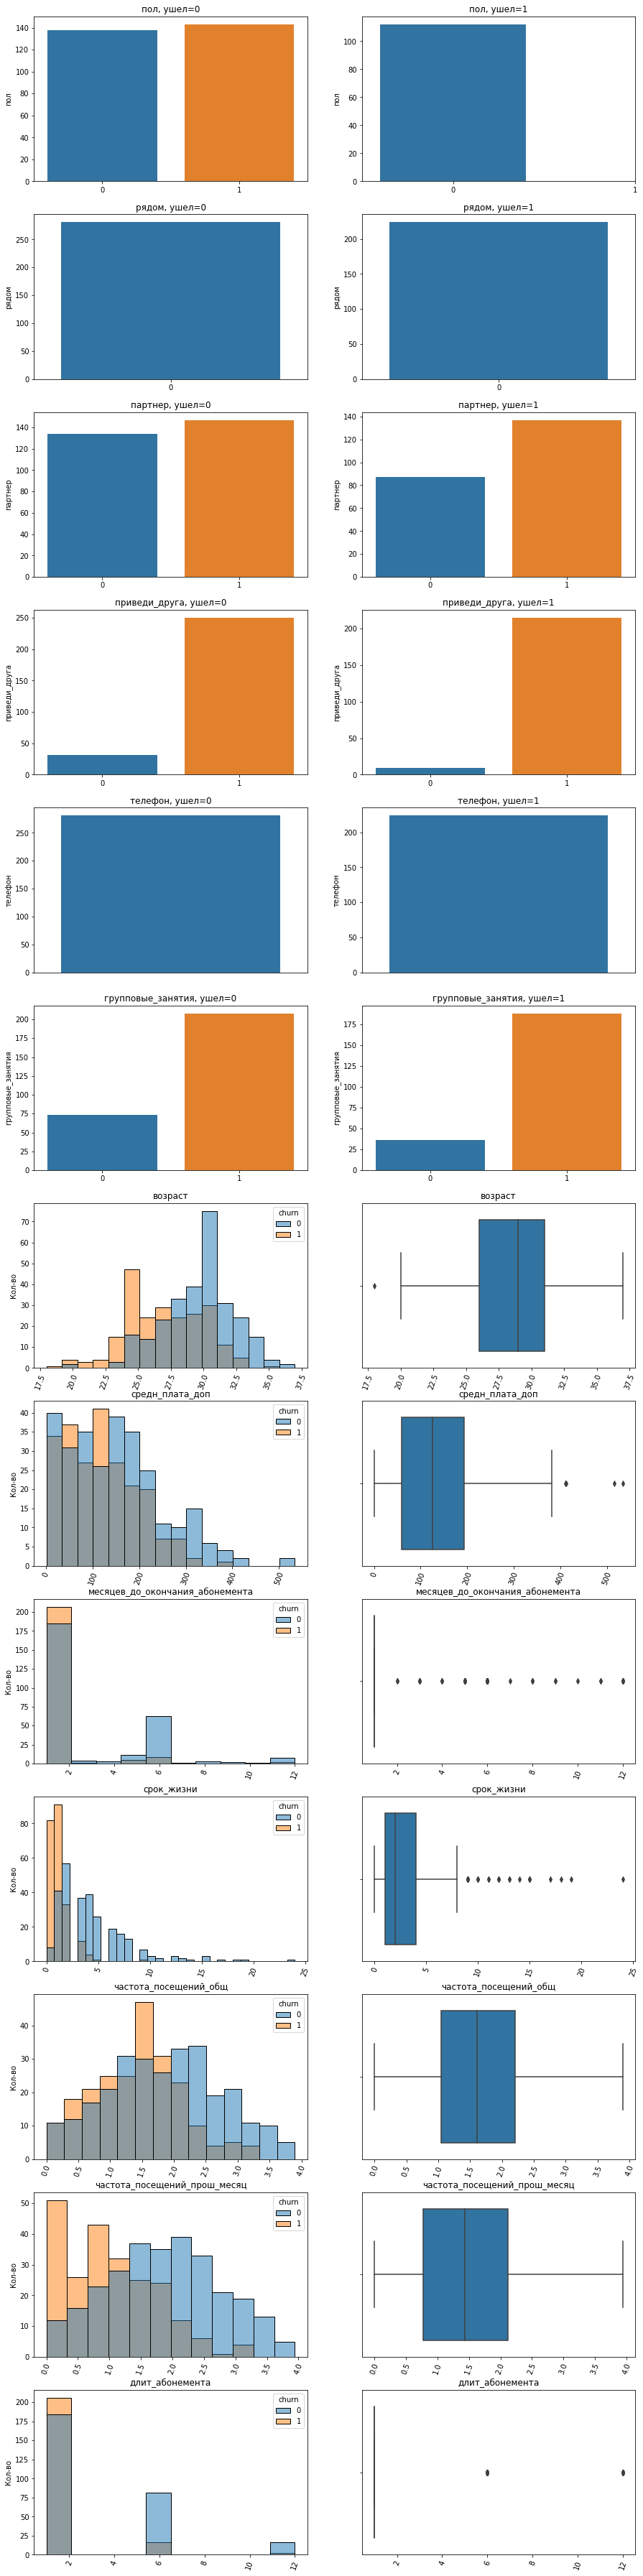

'Графики для кластера долговременные'

'Отток для кластера долговременные составляет 28 чел. из 1010 чел.'

'Доля оттока для кластера долговременные составляет 2.77%'

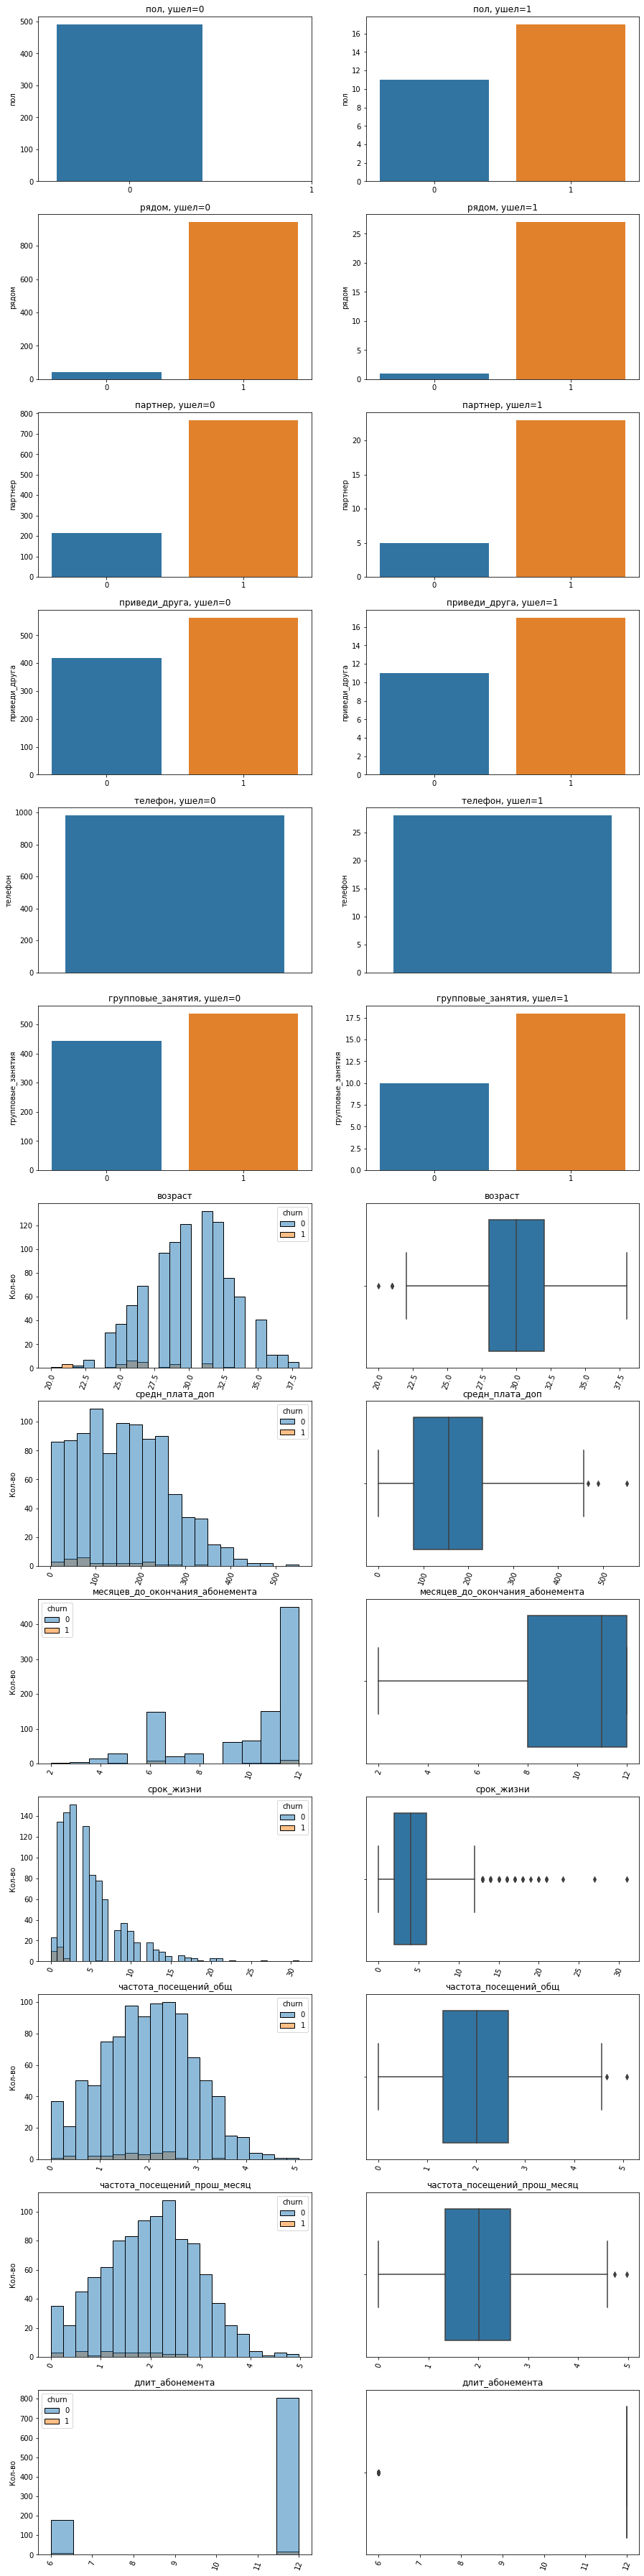

'Графики для кластера молодые'

'Отток для кластера молодые составляет 649 чел. из 1262 чел.'

'Доля оттока для кластера молодые составляет 51.43%'

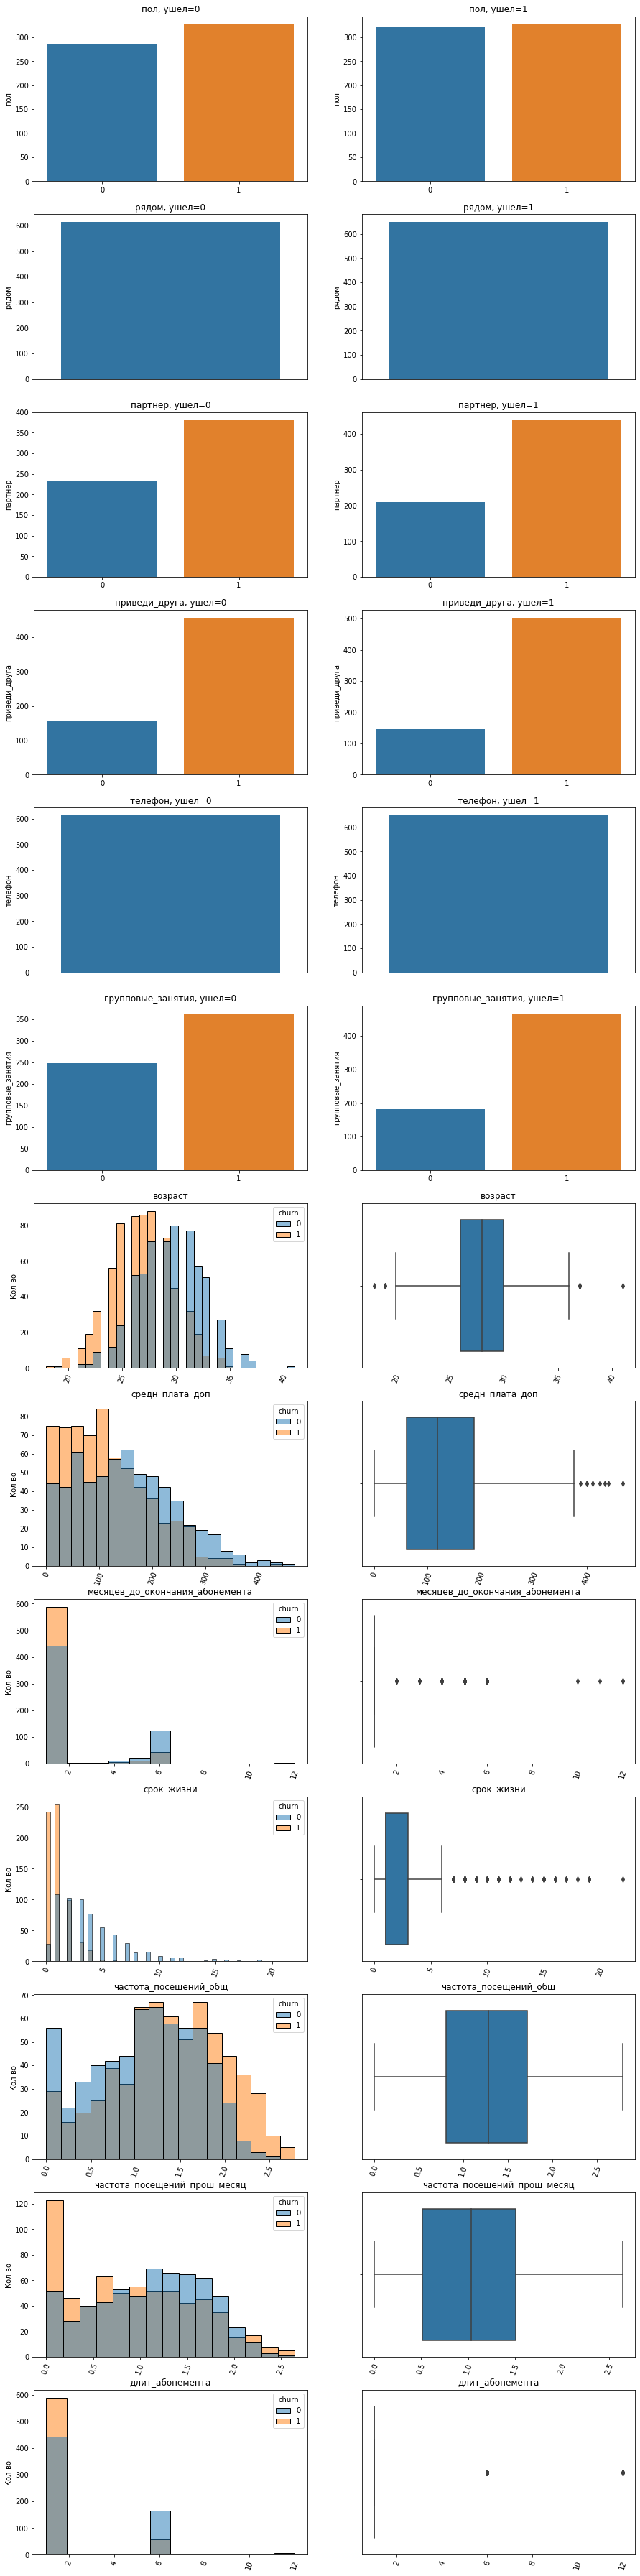

In [36]:
for i in raw_data['cluster_id'].sort_values().unique():
    display('Графики для кластера ' + str(i))
    display(
        'Отток для кластера ' + str(i) + ' составляет ' + str(
            raw_data.loc[raw_data['cluster_id']==i,'churn'].sum()
        ) + ' чел. из ' +  str(len(raw_data.loc[raw_data['cluster_id']==i])) + ' чел.')
    display(
        'Доля оттока для кластера '+ str(i) + 
        ' составляет ' + 
        str((raw_data.loc[raw_data['cluster_id']==i,'churn'].sum()
             /len(raw_data.loc[raw_data['cluster_id']==i])*100).round(2)) + '%')
    plot_df(raw_data.loc[raw_data['cluster_id']==i].drop(columns='cluster_id'),2,15,5,'churn')

In [37]:
display(raw_data.groupby(['cluster_id']).agg('mean').transpose())
new_data=raw_data.groupby(['cluster_id']).agg(count=('churn',np.size),share=('churn',np.size), churn = ('churn', np.mean))
new_data['churn']=new_data['churn'].round(2)
new_data['share']=(new_data['share']/new_data['share'].sum()).round(2)
display(new_data.transpose())

cluster_id,активные,без_телефона,далеко,долговременные,молодые
gender,0.559666,0.522078,0.495050,0.502970,0.485737
near_location,0.976134,0.862338,0.000000,0.959406,1.000000
partner,0.356802,0.470130,0.463366,0.783168,0.350238
promo_friends,0.230310,0.306494,0.079208,0.574257,0.240095
phone,0.998807,0.000000,1.000000,1.000000,1.000000
contract_period,2.669451,4.787013,2.352475,10.889109,1.948494
group_visits,0.473747,0.425974,0.215842,0.542574,0.341521
age,30.125298,29.301299,28.477228,29.982178,28.167987
avg_additional_charges_total,161.657905,143.957664,135.457501,160.761016,131.622204
month_to_end_contract,2.459427,4.475325,2.198020,9.954455,1.856577


cluster_id,активные,без_телефона,далеко,долговременные,молодые
count,838.00,385.00,505.00,1010.00,1262.00
share,0.21,0.10,0.13,0.25,0.32
churn,0.07,0.27,0.44,0.03,0.51


Самыми малыми по размеру являютя кластеры "без телефона" и "далеко". Самый большой кластер клиентов - "молодые".

Самая низкая доля оттока - в кластерах "долговременные" и "активные", которые суммарно охватывают практически 50% клиентов.

Самыми надежными кластерами являются "долговременные" - те, у кого средний срок действия абонемента более 4 месяцев, и активные - те, кто посещает центр в среднем более 2,5 раз в неделю.

Наименее надежным кластером выглядят "молодые" клиенты (возраст в среднем 28 лет и менее).

Кластеры "без телефона" и "далеко" слишком невелики, результаты анализа могут быть неверными.

Интересно отметить, что в кластере "долговременные" не уходят клиенты пола 0, а в кластере "далеко" уходят в первую очередь клиенты пола 1. На данный момент делать серьезные выводы на основании этого наблюдения мы не можем, но может быть целесообразным собрать дополнительные данные для анализа этой тенденции.

Из активных клиентов уходят клиенты, которые не оставляли номер телефона, остаются - те, кто оставляли

Из наблюдений можно сделать такие выводы: уходят чаще всего молодые клиенты.

### Анализ  уходящих клиентов

Для того, чтобы вычленить характерные признаки клиентов, которые в скором времени уйдут, посмотрим признаки только таких клиентов.

In [38]:
display(raw_data.loc[raw_data['churn']==1].drop(columns='churn').groupby(['cluster_id']).agg('mean').transpose())

cluster_id,активные,без_телефона,далеко,долговременные,молодые
gender,0.561404,0.524272,0.500000,0.607143,0.503852
near_location,1.000000,0.796117,0.000000,0.964286,1.000000
partner,0.298246,0.388350,0.388393,0.821429,0.323575
promo_friends,0.122807,0.155340,0.040179,0.607143,0.224961
phone,1.000000,0.000000,1.000000,1.000000,1.000000
contract_period,1.614035,1.796117,1.455357,9.857143,1.471495
group_visits,0.403509,0.330097,0.160714,0.357143,0.280431
age,28.157895,27.145631,26.982143,26.678571,26.878274
avg_additional_charges_total,123.349744,108.918677,118.281581,124.511659,113.824339
month_to_end_contract,1.561404,1.757282,1.401786,9.107143,1.425270


Видим, что многие показатели "уходящих" клиентов значительно ниже, чем аналогичные средние показатели клиентов в соответствующих группах.
Усредним, чтобы составить портрет уходящего клиента.

In [39]:
display(raw_data.loc[raw_data['churn']==1].drop(columns=['churn', 'cluster_id']).mean().transpose().round(2))

gender                                 0.51
near_location                          0.77
partner                                0.36
promo_friends                          0.18
phone                                  0.90
contract_period                        1.73
group_visits                           0.27
age                                   26.99
avg_additional_charges_total         115.08
month_to_end_contract                  1.66
lifetime                               0.99
avg_class_frequency_total              1.47
avg_class_frequency_current_month      1.04
dtype: float64

Средний портрет клиента, склонного к прекращению занятий в фитнес-центре, таков:
- молодой человек или девушка в возрасте около 27 лет
- тратит на дополнительные услуги фитнес-центра около 115 рублей
- посещает занятия в целом не чаще 3 раз в три недели, за последний месяц посещает занятия 1 раз в неделю
- ходит в центр около 1 месяца
- срок действия абонемента - около 2 месяцев
- групповые занятия практически не посещает

In [40]:
display(raw_data.loc[raw_data['churn']==0].drop(columns=['churn', 'cluster_id']).mean().transpose().round(2))

gender                                 0.51
near_location                          0.87
partner                                0.53
promo_friends                          0.35
phone                                  0.90
contract_period                        5.75
group_visits                           0.46
age                                   29.98
avg_additional_charges_total         158.45
month_to_end_contract                  5.28
lifetime                               4.71
avg_class_frequency_total              2.02
avg_class_frequency_current_month      2.03
dtype: float64

Средний портрет клиента, склонного к продолжению занятий в фитнес-центре, таков:
- молодой человек или девушка в возрасте около 30 лет
- тратит на дополнительные услуги фитнес-центра около 160 рублей
- посещает занятия в целом 2 раза в неделю, за последний месяц посещает занятия 2 раза в неделю (или больше)
- ходит в центр около 4,5 месяцев
- срок действия абонемента - около более 5 месяцев
- групповые занятия посещает с вероятностью в 50%

In [41]:
compare_data = raw_data.groupby(['cluster_id']).agg('mean')-raw_data.loc[raw_data['churn']==1
                                                                        ].groupby(['cluster_id']).agg('mean')
#for i in compare_data.columns:
#    if abs(compare_data[i].min()) < abs(compare_data[i].max()):
#        compare_data.loc[5,i]=1
#    else:
#        compare_data.loc[5,i]=0
display(compare_data.drop(columns='churn').round(2).transpose().style.apply(b_g, axis=1))
display('Среднее различие в характеристиках между средним для группы и средним для уходящих клиентов')
display(compare_data.drop(columns='churn').mean().round(2).transpose())

cluster_id,активные,без_телефона,далеко,долговременные,молодые
gender,-0.000000,-0.000000,-0.000000,-0.100000,-0.020000
near_location,-0.020000,0.070000,0.000000,-0.000000,0.000000
partner,0.060000,0.080000,0.070000,-0.040000,0.030000
promo_friends,0.110000,0.150000,0.040000,-0.030000,0.020000
phone,-0.000000,0.000000,0.000000,0.000000,0.000000
contract_period,1.060000,2.990000,0.900000,1.030000,0.480000
group_visits,0.070000,0.100000,0.060000,0.190000,0.060000
age,1.970000,2.160000,1.500000,3.300000,1.290000
avg_additional_charges_total,38.310000,35.040000,17.180000,36.250000,17.800000
month_to_end_contract,0.900000,2.720000,0.800000,0.850000,0.430000


'Среднее различие в характеристиках между средним для группы и средним для уходящих клиентов'

gender                               -0.03
near_location                         0.01
partner                               0.04
promo_friends                         0.06
phone                                -0.00
contract_period                       1.29
group_visits                          0.09
age                                   2.04
avg_additional_charges_total         28.91
month_to_end_contract                 1.14
lifetime                              2.78
avg_class_frequency_total             0.19
avg_class_frequency_current_month     0.45
dtype: float64

Для того, чтобы отобразить только значимые отличия, округляем значения до сотых.
Красным отражены наибольшие по модулю величины различий.

Если значение в таблице отрицательное, это означает, что у уходящих клиентов группы оно превышает среднее для группы.

Видим, что уходящие клиенты в среднем на 2 года моложе среднего для группы, их траты на прочие услуги центра меньше на 28.91 у.е., занимаются они на 2,8 месяца меньше, а средняя частота занятий в текущем месяце на 0,45 меньше, чем в среднем для группы.

## Выводы и рекомендации

### Выводы

На основании проведенного анализа можно особо выделить 2 группы клиентов с наибольшим уровнем оттока, ключевое различие между ними заключается в признаке "near_location": в группе 2 клиенты не проживают и не работают рядом с центром,в группе 3 - наборот, проживают или работают рядом с центром.

Также наблюдается некоторое различие в прочих тратах: клиенты из группы 2 тратят несколько больше клиентов группы 3 на прочие услуги.

По прочим характеристикам клиенты очень близки: средний возраст не более 28,5 лет, приблизительно одинаковый половой состав, срок действия абонемента тоже достаточно близкий.

При этом некоторые характеристики у клиентов из группы 2 совпадают с хараткеристиками клиентов из группы 4, в частности, срок действия абонемента, а доля клиентов группы 2, работающих в компаниях-партнерах фитнес-центра даже больше, чем в группе 4.

Можно предположить, что клиенты из этой группы "отваливаются" из-за расстояния до фитнес-центра.

В группе 3, характеризующейся наибольшей долей уходящих клиентов, самый низкий средний возраст клиента, при этом группа хараткеризуется тем, что все ее члены проживают или работают рядом с фитнес-центром, то есть причина ухода из центра не связана с логистикой. Также клиенты из группы 3 тратят меньше всего денег на дополнительные услуги фитнес-центра, следовательно, возможно их не устраивают цены в фитнес-центре.

Клиенты с высокой степенью вероятности становятся постоянными после 4,5 месяцев посещения фитнес-центра (скорее всего, это связано с формированием привычки и рутины).

### Рекомендации

- Возможно, стоит проработать вариант с маркетинговой кампанией, например, по предоставлению скидки на дополнительные услуги центра новым клиентам, новыми считать тех, кто ходит менее 6 месяцев.

- Еще один показатель, по которому постоянные клиенты отличаются от уходящих - доля групповых занятий. В группах 0 и 4 эта доля превышает 0,47, в группах 2 и 3 она составляет - 0,22 и 0,34 соответственно.

- В группе 2 клиенты живут/работают далеко от фитнес-центра, и высока вероятность, что они просто не успевают прийти на групповые занятия, даже если хотят. В связи с этим возможно скорректировать время проведения групповых занятий с учетом анкетирования таких клиентов - уточнить у них удобное время для занятий (либо - взять данные о времени посещения фитнес-центра).

- Что касается группы 3 - возможно, в арсенале фитнес-центра нет групповых занятий, интересных для этой категории клиентов. Имеет смысл провести анкетирование для того, чтобы выделить наиболее интересные направления групповых занятий и закрыть, таким образом, одну из потребностей людей.

- Если клиент из любой группы резко снижает частоту походов в зал (падение до уровня 3 раз в две недели или менее), перестает посещать групповые занятия и снижает траты на дополнительные услуги фитнес-центра, возможно, с ним следует провести индивидуальную работу - уточнить, что не устраивает; предложить бонусы или скидки.